In [91]:
#imports
from datetime import datetime as dt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

### Loading Datasets

In [92]:
# file path
file_path="C:/Users/Davie/Desktop/introduction-to-power-bi/"

In [93]:
#load demographic data
demographic=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerDemographic', index_col=False, header=0, usecols="A:M", skiprows=1)

In [94]:
#load customer address
address=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerAddress', index_col=False, header=0, usecols="A:F", skiprows=1)

In [95]:
#load transaction data
transactions=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='Transactions', index_col=False, header=0, usecols="A:M", skiprows=1)

### Merging the datasets

In [96]:
#merge demographic data with customer address
demographic_address=pd.merge(demographic, address, on='customer_id', how='inner')

In [97]:
#merged all the 3 datasets
demographic_address_transactions=pd.merge(demographic_address, transactions, on='customer_id', how='inner')

In [98]:
#drop duplicates and ulls
df=demographic_address_transactions.drop_duplicates().dropna()

In [99]:
#make copy of the data
data=df.copy()

### Feature engineering

In [100]:
#calculate profit margin
data['profit_margin']=data['list_price']-data['standard_cost']

In [101]:
#calculate product margin
data['product_margin']=(data['list_price']-data['standard_cost'])/data['list_price']

In [102]:
# Calculate age

# convert DOB to datetime
data['DOB']=pd.to_datetime(data['DOB'])
# Get the current date
current_date = pd.to_datetime('today')
# Calculate age using apply and a lambda function to handle the year difference
data['age'] = df['DOB'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)))

In [103]:
# Define age bins and labels
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['0-25','25-35', '35-45', '45-55', '55-65', 'Above 65']

# Create age groups
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

In [104]:
# date of transaction
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Extract the daya, monthand year from transaction_date
data['trans_day'] = data['transaction_date'].dt.day
data['trans_month'] = data['transaction_date'].dt.month

In [105]:
# Replace values for gender and state in the entire DataFrame
data['gender'] = data['gender'].replace({'Femal': 'Female', 'F': 'Female'})
data['state']=data['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})

### Distribution for Bikes Purchased to be used as the target variable

<Axes: ylabel='Frequency'>

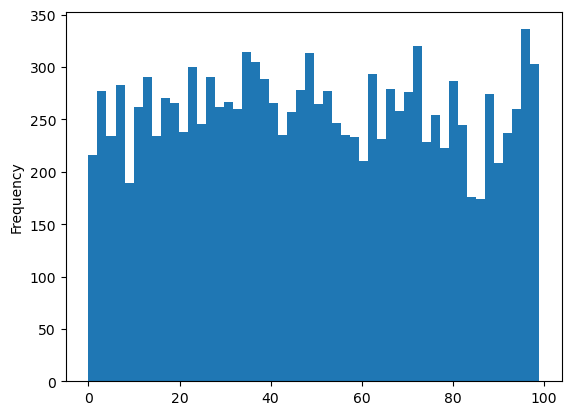

In [106]:
#histogram
data['past_3_years_bike_related_purchases'].plot.hist(bins=50)

<Axes: >

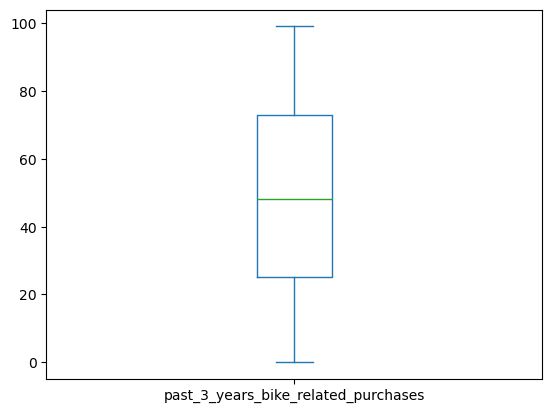

In [107]:
#box plot
data['past_3_years_bike_related_purchases'].plot.box()

### Columns

In [108]:
#checking new columns
data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'address', 'postcode', 'state',
       'country', 'property_valuation', 'transaction_id', 'product_id',
       'transaction_date', 'online_order', 'order_status', 'brand',
       'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'profit_margin',
       'product_margin', 'age', 'age_group', 'trans_day', 'trans_month'],
      dtype='object')

In [109]:
#select columns to use in the Model
cols=['gender', 'age', 'age_group', 'trans_month', 'trans_day', 'state', 'job_industry_category' ,'job_title', 'online_order', 'order_status' ,'wealth_segment',  'brand','product_line', 'product_class', 'product_size', 'tenure', 'past_3_years_bike_related_purchases', 'profit_margin', 'product_margin']

In [110]:
#select model columns
data=data[cols]

In [111]:
#drop nulls
data_clean=data.dropna()

### Encoding
- Choose the encoding method based on the nature of your data and the requirements of your machine learning model. 
- `One-hot encoding` is suitable when there is no ordinal relationship between categories
- `label encoding` is useful when there is an ordinal relationship between categories. 
- **Example**
    - Label encoding for Ordinal Variables
    - `ordinal_mapping_prod_size = {'small': 0, 'medium': 1, 'large': 2} #product size`
    - `ordinal_data['product_size'] = ordinal_data['product_size'].map(ordinal_mapping_prod_size)`
    - `data.reset_index(drop=True, inplace=True)`  # Reset index of X without adding it as a new column
- Always remember to handle unknown categories appropriately, especially when using one-hot encoding.

In [112]:
# Creating binary variable from continous variable

#create threshold
threshold=data['past_3_years_bike_related_purchases'].median()
# create high buyers and low buyers
data_clean['bikes_purchased']=(data_clean['past_3_years_bike_related_purchases']>threshold).astype(int)

In [113]:
# Select categorical columns
categorical_cols = ['gender', 'age_group', 'state', 'job_industry_category', 'job_title', 
                    'order_status', 'wealth_segment', 'brand', 'product_line', 'product_class', 'product_size']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each column
for col in categorical_cols:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])

# Display the updated DataFrame
data_clean.head()

,gender,age,age_group,trans_month,trans_day,state,job_industry_category,job_title,online_order,order_status,wealth_segment,brand,product_line,product_class,product_size,tenure,past_3_years_bike_related_purchases,profit_margin,product_margin,bikes_purchased
0,0,70,5,12,23,0,3,71,0.0,0,2,2,2,2,1,11.0,93,110.56,0.469210,1
1,0,70,5,4,6,0,3,71,1.0,0,2,3,2,2,1,11.0,93,751.02,0.476073,1
2,0,70,5,5,11,0,3,71,1.0,0,2,4,1,1,2,11.0,93,189.28,0.110002,1
3,0,70,5,1,5,0,3,71,0.0,0,2,1,2,2,1,11.0,93,90.10,0.250000,1
4,0,70,5,2,21,0,3,71,0.0,0,2,3,2,2,1,11.0,93,17.87,0.249965,1


In [114]:
cols_encoded=['age', 'trans_day', 'trans_month', 'product_margin','bikes_purchased','trans_day', 'profit_margin', 
              'product_size', 'product_class', 'gender', 'age_group', 'state', 'job_industry_category' ,'job_title', 
              'online_order', 'order_status','wealth_segment', 
              'brand', 'product_line']

In [115]:
# make copy
model_data=data_clean.copy()

In [116]:
'''# For simplicity, let's assume we rename duplicated columns by appending "_dup"
cols = pd.Series(model_data.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_dup' if i != 0 else dup for i in range(sum(cols == dup))]

# Assign the new columns back to the dataframe
model_data.columns = cols'''

'# For simplicity, let\'s assume we rename duplicated columns by appending "_dup"\ncols = pd.Series(model_data.columns)\nfor dup in cols[cols.duplicated()].unique():\n    cols[cols[cols == dup].index.values.tolist()] = [dup + \'_dup\' if i != 0 else dup for i in range(sum(cols == dup))]\n\n# Assign the new columns back to the dataframe\nmodel_data.columns = cols'

In [117]:
# Select relevant features and the target variable
X = model_data.drop(columns=['bikes_purchased'])
y = model_data['bikes_purchased']

In [118]:
# Identify categorical and numerical columns
categorical_features = ['gender', 'age_group', 'state', 'job_industry_category', 'job_title', 
                        'order_status', 'wealth_segment', 'brand', 'product_line', 'product_class', 'product_size']
numerical_features = ['age', 'product_margin', 'profit_margin', 'trans_day', 'trans_month']

### RANDOM FOREST CLASSIFICATION
- NO imbalance in the target variable

In [121]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score: {r2_score(y_test, y_pred)}')

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best Mean Squared Error:', -grid_search.best_score_)  # Convert back to positive MSE

Mean Squared Error: 0.06914814957594449
R^2 Score: 0.7232874859052738


KeyboardInterrupt: 

### LINEAR RGRESSION

In [122]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with LinearRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.23420578427098657
R^2 Score: 0.06277070639505178


### DECISSION TREE

In [ ]:
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with DecisionTreeRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score: {r2_score(y_test, y_pred)}')

# Hyperparameter tuning
param_grid = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best Mean Squared Error:', -grid_search.best_score_)  # Convert back to positive MSE

# Use the best estimator for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Final evaluation of the tuned model
print(f'Mean Squared Error (tuned): {mean_squared_error(y_test, y_pred)}')
print(f'R^2 Score (tuned): {r2_score(y_test, y_pred)}')

#### Q: Based on age group, gender, and state, what are the key target demographics for bike purchases?

#### Q2: Predictive Modeling:
- Can you build a model to predict the likelihood of bike purchases based on demographic and product characteristics?

### LOGISTIC REGRESSION
- Logistic regression is used for classification tasks, not regression. Since you want to predict the likelihood of bike purchases, which is a binary classification problem, logistic regression is indeed appropriate.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Convert the target variable to binary if it isn't already
y = y.apply(lambda x: 1 if x >0 else 0)  # Assuming bike_purchases &gt; 0 means a purchase

# Identify categorical and numerical columns
'''categorical_features = ['gender', 'age_group', 'state', 'job_industry_category', 'job_title', 
                        'order_status', 'wealth_segment', 'brand', 'product_line', 'online_order']
numerical_features = ['age', 'product_margin', 'profit_margin', 'trans_day', 'trans_month']'''

# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with LogisticRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best ROC AUC Score:', grid_search.best_score_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Final evaluation of the tuned model
print(f'Accuracy (tuned): {accuracy_score(y_test, y_pred)}')
print(f'Precision (tuned): {precision_score(y_test, y_pred)}')
print(f'Recall (tuned): {recall_score(y_test, y_pred)}')
print(f'F1 Score (tuned): {f1_score(y_test, y_pred)}')
print(f'ROC AUC Score (tuned): {roc_auc_score(y_test, y_pred)}')

# Interpreting the LOGISTIC CLASSIFIER

In [ ]:
# Interpret the model coefficients
# Get the feature names after one-hot encoding and scaling
onehot_columns = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = np.hstack([numerical_features, onehot_columns])

# Get the coefficients from the logistic regression model
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficient to see the most influential features
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

print(coef_df)

In [ ]:
# Filter coefficients for negative contribution to bike purchases
negative_coef_df = coef_df[coef_df['Coefficient'] < 0]

# Sort coefficients in ascending order (from most negative to least negative)
negative_coef_df = negative_coef_df.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients for negative contribution to bike purchases
plt.figure(figsize=(10, 6))
plt.barh(negative_coef_df['Feature'], negative_coef_df['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Negative Contribution to Bike Purchases (Most Negative to Least Negative)')
plt.grid(axis='x')
plt.show()

In [ ]:
# Filter coefficients for negative contribution to bike purchases
negative_coef_df = coef_df[coef_df['Coefficient'] < 0]

# Group coefficients by feature category
grouped_negative_coef_df = negative_coef_df.groupby('Feature').sum().reset_index()

# Sort coefficients in ascending order (from most negative to least negative)
grouped_negative_coef_df = grouped_negative_coef_df.sort_values(by='Coefficient', ascending=True)

# Plot the summarized coefficients for negative contribution to bike purchases
plt.figure(figsize=(10, 6))
plt.barh(grouped_negative_coef_df['Feature'], grouped_negative_coef_df['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Summarized Logistic Regression Coefficients for Negative Contribution to Bike Purchases')
plt.grid(axis='x')
plt.show()

In [ ]:
# Filter coefficients for positive influence
positive_coef_df = coef_df[coef_df['Coefficient'] > 0]

# Sort coefficients in descending order
positive_coef_df = positive_coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients for positive influence
plt.figure(figsize=(10, 40))
plt.barh(positive_coef_df['Feature'], positive_coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Positive Influence')
plt.grid(axis='x')
plt.show()

- Use RandomForestRegressor when your target variable is a continuous value that you need to predict.
- Use RandomForestClassifier when your target variable is a categorical label or class.